In [1]:
import os
import nibabel as nib
import numpy as np
from torch.utils.data import Dataset
import torch
from PIL import Image
import matplotlib.pyplot as plt

#from collections import OrderedDict

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torch.utils.checkpoint as checkpoint
import torch.utils.data
from torch.utils.data import random_split

import torchio as tio
import torchio.transforms as transforms

from PIL import Image

import random
import math

In [2]:
from tools import crop_tensor

In [3]:
"""
Data loading: Load the BRATS data from different formats (e.g., NIfTI, HDF5).

Data augmentation: Apply common augmentations for medical images, such as rotations, scaling, flipping, and elastic transformations.

Conversion utilities: Convert the data to different formats suitable for different types of models (e.g., 2D, 3D, multi-channel).

Metrics: Implement common segmentation metrics, such as Dice coefficient, Jaccard index, sensitivity, specificity, and Hausdorff distance.

Benchmarks: Include functions to evaluate a model's performance using the above metrics and compare it against benchmark results on the BRATS dataset.

Visualization: Include functions to visualize the original images, ground truth segmentations, and model predictions.
"""

"\nData loading: Load the BRATS data from different formats (e.g., NIfTI, HDF5).\n\nData augmentation: Apply common augmentations for medical images, such as rotations, scaling, flipping, and elastic transformations.\n\nConversion utilities: Convert the data to different formats suitable for different types of models (e.g., 2D, 3D, multi-channel).\n\nMetrics: Implement common segmentation metrics, such as Dice coefficient, Jaccard index, sensitivity, specificity, and Hausdorff distance.\n\nBenchmarks: Include functions to evaluate a model's performance using the above metrics and compare it against benchmark results on the BRATS dataset.\n\nVisualization: Include functions to visualize the original images, ground truth segmentations, and model predictions.\n"

In [4]:
class RandomChannelReplace:
    def __init__(self, mean=0, std=1, channels=4, p=0.5):
        self.mean = mean
        self.std = std
        self.channels = channels
        self.p = p

    def __call__(self, image):
        if np.random.rand() < self.p:
            channel_to_replace = np.random.randint(self.channels) # from 0 to 3 by default 
            noise = np.random.normal(self.mean, self.std, size=image[channel_to_replace].shape)
            image[channel_to_replace] = torch.tensor(noise)
        return image


class RandomCrop3D:
    """
    Custom module for 3D images as torchvision does not support 3D images
    output_size - a tuple (x, y, z)
    """
    def __init__(self, output_size):
        self.output_size = output_size

    def __call__(self, sample):
        x, y, z = sample.shape[-3:]
        x_start = np.random.randint(0, x - self.output_size[0])
        y_start = np.random.randint(0, y - self.output_size[1])
        z_start = np.random.randint(0, z - self.output_size[2])
        return sample[..., x_start:x_start+self.output_size[0], y_start:y_start+self.output_size[1], z_start:z_start+self.output_size[2]]

In [25]:
"""
About BRATS2021:
0: Background - This class represents the healthy brain tissue and is the majority class in the dataset.
1: Necrosis and Non-Enhancing Tumor - This class represents the non-enhancing tumor and the necrotic core of the enhancing tumor.
2: Edema - This class represents the edema surrounding the tumor.
3: Enhancing Tumor - This class represents the enhancing tumor.

Settings:
One-hot tensor - 
Crop by non-zero - 
Normalization - 

Augmentations:
Random Crop - 
Random Flip - 
Random Axes Transpose - 
"""

default_augmentations = {
    "random_crop": {
        "size": (72, 72, 72),
        "p": 1.0
    },
    "random_flip": {
        "p": 0.25
    },
    "random_axes_transpose": {
        "p": 0.1
    },
    "random_channel_gauss": {
        "mean" : 0, 
        "std" : 1, 
        "channels" : 4,
        "p": 0.2
    }
}

class ClearBRATS(Dataset):
    def __init__(self, data_dir):
        self.data_dir = data_dir
        self.patient_ids = os.listdir(data_dir)

    def __len__(self):
        return len(self.patient_ids)
    
    def __getitem__(self, idx):
        patient_id = self.patient_ids[idx]
        scan_files = [os.path.join(self.data_dir, patient_id, f'{patient_id}_{modality}.nii.gz')
                      for modality in ['t1', 't2', 't1ce', 'flair']]
        mask_file = os.path.join(self.data_dir, patient_id, f'{patient_id}_seg.nii.gz')
        
        scans = []
        for scan_file in scan_files:
            scan_data = nib.load(scan_file).get_fdata()
            scans.append(scan_data)
        scans_tensor = np.stack(scans, axis=0)
        
        # Load mask file and convert to integer labels
        mask_data = nib.load(mask_file).get_fdata()
        mask_tensor = (mask_data > 0).astype(np.int64) + (mask_data == 4).astype(np.int64) * 2

        return scans_tensor, mask_tensor

class AbstractBRATS(Dataset):
    def __init__(self, dataset, normalized=True, add_onehot=True, is_cropped=False, augmentation_config=None):
        self.dataset = dataset
        self.is_cropped = is_cropped
        self.add_onehot = add_onehot
        self.normalized = normalized
        self.augmentation_config = augmentation_config

    def __len__(self):
        return len(self.dataset)

    def montage_display(self, idx, channel = 0, figsize=(10, 10)):
        scans_tensor, mask_tensor = self.__getitem__(idx)
        scan_mask_merged = torch.cat([scans_tensor, mask_tensor.unsqueeze(dim = 0)], dim=0).numpy()
        input_array = scan_mask_merged[channel]
        z, x, y = input_array.shape

        # Calculate number of plot rows and columns
        rows = int(math.sqrt(z))
        cols = math.ceil(z / rows)

        # Create a new figure
        fig, axs = plt.subplots(rows, cols, figsize=figsize)

        # Iterate through each 2D slice
        for i in range(z):
            # Calculate subplot row and column
            r, c = i // cols, i % cols

            # Plot 2D slice at subplot [r, c]
            axs[r, c].imshow(input_array[i], cmap='gray')
            axs[r, c].axis('off')

        plt.show()

    def slice_display(self, idx, slice_num = 10, figsize=(15, 5)):
        scan, mask = self.__getitem__(idx)
        slice_idx = slice_num

        num_channels = scan.shape[0] + 1

        # Visualize the scan and mask using matplotlib
        fig, axs = plt.subplots(1, num_channels, figsize=figsize)
        for i in range(num_channels - 1):
            axs[i].imshow(scan[i][:, :, slice_idx], cmap='gray')
            axs[i].set_title(f'Modality {i+1}')
        axs[num_channels - 1].imshow(mask[:, :, slice_idx], cmap='gray')
        axs[num_channels - 1].set_title('Segmentation Mask')
        plt.show()


    def __getitem__(self, idx):
        scans_tensor, mask_tensor = self.dataset[idx]

        # Normalize scans and convert to PyTorch tensor
        if self.normalized == True:
            for channel_num in range(scans_tensor.shape[0]):
                channel_data = scans_tensor[channel_num]
                channel_data = scans_tensor[channel_num]
                non_zero_indices = np.nonzero(channel_data)

                mean = np.mean(channel_data[non_zero_indices])
                std = np.std(channel_data[non_zero_indices])

                channel_data[non_zero_indices] -= mean
                channel_data[non_zero_indices] /= std
                
                scans_tensor[channel_num] = channel_data

        scans_tensor = torch.from_numpy(scans_tensor)
        mask_tensor = torch.from_numpy(mask_tensor)

        # Add the last one-hot layer
        if self.add_onehot:
            one_hot = (scans_tensor[0]!= 0)*1.0
            one_hot = one_hot.unsqueeze(dim = 0) # Add channel dimensions
            scans_tensor = torch.cat([scans_tensor, one_hot], dim=0)

        if self.is_cropped: 
            scans_tensor = torch.cat([scans_tensor, mask_tensor.unsqueeze(dim = 0)], dim=0)
            scans_tensor = crop_tensor (scans_tensor)
            mask_tensor = scans_tensor[-1][:]
            scans_tensor = scans_tensor[:-1][:]

        # Augmentations
        if self.augmentation_config != None:
            # Merge scans and mask to ensure that augmentations are the same for both
            scan_mask_merged = torch.cat([scans_tensor, mask_tensor.unsqueeze(dim = 0)], dim=0)

            cfg = self.augmentation_config

            if "random_crop" in cfg:
                pr = random.random()
                if pr <= cfg["random_crop"]["p"]:
                    scan_mask_merged = RandomCrop3D(cfg["random_crop"]["size"])(scan_mask_merged)
            
            if "random_flip" in cfg:
                scan_mask_merged = transforms.RandomFlip(flip_probability = cfg["random_flip"]["p"])(scan_mask_merged)

            # Replaces random channel with a Gaussian distribution
            if "random_channel_gauss":
                mean = cfg["random_channel_gauss"]["mean"]
                std = cfg["random_channel_gauss"]["std"]
                channels = cfg["random_channel_gauss"]["channels"]
                prb = cfg["random_channel_gauss"]["p"]
                scan_mask_merged = RandomChannelReplace (mean=mean, std=std, channels=channels, p=prb)(scan_mask_merged)
            

            mask_tensor = scan_mask_merged[-1][:]
            scans_tensor = scan_mask_merged[:-1][:]


        return scans_tensor.float(), mask_tensor.long()

    def update_settings():
        print ("nothing so far")



# To be reworked
def init_train_test_datasets (data_dir, train_ratio = 0.8):
    start_dataset = ClearBRATS (data_dir)

    train_size = int(train_ratio * len(start_dataset))
    test_size = len(start_dataset) - train_size

    torch.manual_seed(21)
    train_dataset, test_dataset = torch.utils.data.random_split(start_dataset, [train_size, test_size])
    train_dataset = AbstractBRATS (train_dataset, normalized = True, is_cropped = True, add_onehot = True, augmentation_config = default_augmentations)
    test_dataset = AbstractBRATS (test_dataset)

    return train_dataset, test_dataset

In [26]:
# Test the main dataset

data_dir = 'C:/Users/alist/WorkCodes/Datasets/BRATS2021TRAINDATASET'
train_dataset, test_dataset = init_train_test_datasets(data_dir, train_ratio = 0.8)

print(len(train_dataset), len(test_dataset))


# Print shape of scan and mask tensors
#print('Scan tensor shape:', scan.shape)
#print('Mask tensor shape:', mask.shape)
#print('Dataset length', len(dataset))
#print ("max", scan[0].max().item(), "min", scan[0].min().item(), scan[1].mean(), scan[1].std())



#test_dataset.montage_display(0, channel=1)

1000 251


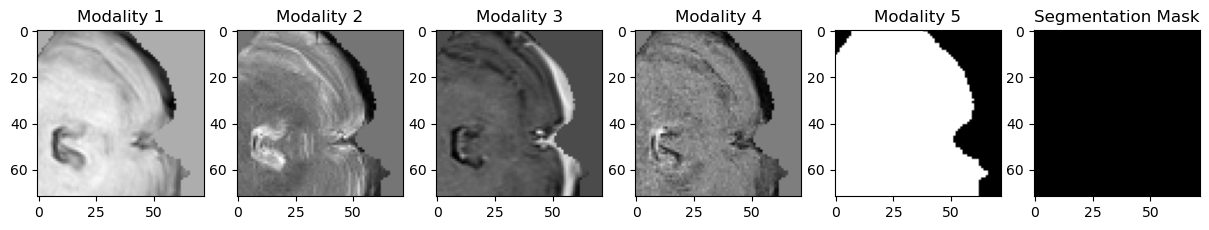

In [27]:
train_dataset.slice_display(0)

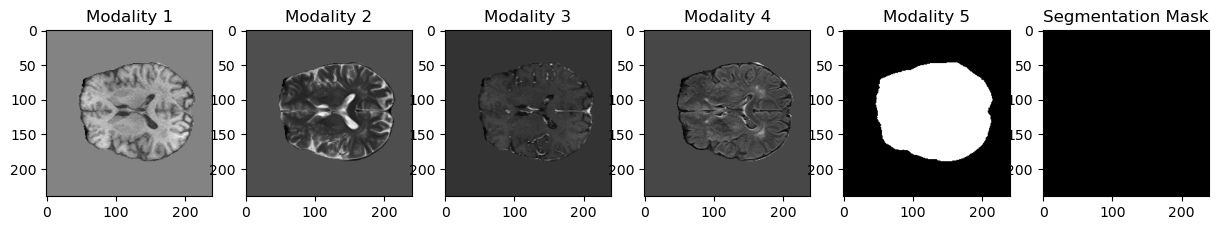

In [28]:
test_dataset.slice_display(0, slice_num = 70)

In [ ]:
dataset_size = len(dataset)

train_size = int(0.8 * dataset_size)  # 80% for training
val_size = dataset_size - train_size  # Remaining 20% for validation

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
print (train_dataset[0])

(tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         ...,

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0.,